### 配置

In [1]:
# 只是为了方便大家体验，不要滥用导致其他人无法体验，尽量用自己的 KEY
API_KEY="09e7ef15-86a5-4b6b-b83d-02902267808a"
BASE_URL ="https://ark.cn-beijing.volces.com/api/v3"
CHAT_MODEL ="doubao-seed-1-6-250615"
EMBEDDING_MODEL ="doubao-embedding-large-text-250515"

### 工具

In [2]:
import requests

# 基础聊天工具
def chat(msg,history=None,summary=None,matches=None):
    messages = [{
        "role": "system",
        "content": "You are a helpful assistant.",
    }]
    if history is not None:
        messages.extend(history)
    if summary is not None:
        messages[0]["content"]+=f" History messages summary:\n{summary}"
    if matches is not None:
        note = ""
        for match in matches:
            note += f"\n{match['role']}: {match['content']}"
        messages[0]["content"]+=f" Related history messages:{note}"
    messages.append({
        "role": "user",
        "content": msg,
    })
    resp = requests.post(
        url=f"{BASE_URL}/chat/completions",
        headers={'Content-Type': 'application/json', 'Authorization': f"Bearer {API_KEY}"},
        json={
            "model": CHAT_MODEL,
            "messages":messages,
        },
    )
    data = resp.json()
    return data['choices'][0]['message']['content']

# 摘要工具
def summary(history,summary=""):
    lines=""
    for msg in history:
        lines += f"{msg['role']}: {msg['content']}\n"
    res= chat(f"""请根据历史总结内容与新的对话内容生成新的总结用于后续记忆摘要

历史总结内容：
{summary}

新的对话内容：
{lines}""")
    return res

# 特征向量获取工具
def embedding(text):
    resp = requests.post(
        url=f"{BASE_URL}/embeddings",
        headers={'Content-Type': 'application/json', 'Authorization': f"Bearer {API_KEY}"},
        json={
            "model": EMBEDDING_MODEL,
            "input":text,
        },
    )
    data = resp.json()
    return data['data'][0]['embedding']

In [136]:
data = embedding("小狗") # 测试 embedding
print(len(data))
print(data[:9])

2048
[-0.2099609375, 1.8984375, 1.796875, -0.8203125, -1.0078125, -0.283203125, -0.82421875, 0.23828125, 0.546875]


### 测试

#### 相同输入测试

In [ ]:
for i in range(3):
    print(chat("你好"))

#### 记忆测试

In [ ]:
print(chat("你好，我叫邵康！"))
print(chat("你知道我叫什么吗？"))

#### 携带全部历史记录

In [22]:
history =[]
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,history=history)
    print(f"AI:{content}")
    history.extend([{
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }])

用户:你好
AI:你好！有什么我可以帮你的吗？
用户:我叫邵康
AI:你好，邵康！很高兴认识你！有什么我可以帮你的吗？😊
用户:你知道我是谁吗？
AI:你好，邵康！虽然我不能真正“知道”你是谁，但我很乐意了解你。你可以告诉我更多关于你的兴趣、想法或需要帮助的地方吗？我很高兴能和你交流！😊


#### 只保留最近 n 条历史记录

In [28]:
history =[]
n = 4
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,history=history)
    print(f"AI:{content}")
    history.extend([{
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }])
    while len(history) > n:
        history.pop(0)

用户:你好，我叫邵康
AI:你好，邵康！很高兴认识你。有什么我可以帮你的吗？
用户:你是 AI 吗？
AI:是的，我是一个AI助手。我叫通义千问，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我可以帮助你回答问题、创作文字、编程、思考问题等等。你可以问我任何问题，我会尽力为你提供帮助。有什么我可以帮你的吗？
用户:你太🐂🍺啦
AI:哈哈，谢谢夸奖！不过我更希望我们能成为好朋友，一起学习、一起进步。你有什么想聊的或者需要帮助的吗？我很乐意陪你聊天或者帮你解决问题。
用户:那你知道我谁谁吗？
AI:哈哈，我可能不太知道你是谁，但我很乐意认识你！你可以告诉我你的名字或者更多关于你的信息，这样我们就可以更熟悉了。你想和我分享些什么吗？


#### 相似度召回

In [3]:
def get_vec_dot(v1,v2):
    res =0
    for i in range(len(v1)):
        res += v1[i]*v2[i]
    return res

def get_best_match(msg,n=2):
    emb = embedding(msg)
    arr =[]
    for item in history:
        arr.append((get_vec_dot(item["embedding"],emb),item))
    arr.sort(key=lambda x:x[0],reverse=True)
    res =[]
    for item in arr[:n]:
        print(f"{item[0]}\t{item[1]['role']}\t{item[1]['content']}")
        res.append(item[1])
    return res

history=[]
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    matches = get_best_match(msg)
    content = chat(msg=msg,matches=matches)
    print(f"AI:{content}")
    history.extend([{
        "role": "user",
        "content": msg,
        "embedding":embedding(msg),
    },{
        "role": "assistant",
        "content": content,
        "embedding":embedding(content),
    }])

用户:我是邵康，你是？
AI:你好，邵康！我是豆包，是由字节跳动公司开发的智能助手。很高兴认识你，有什么我可以帮你的吗？
用户:我最喜欢玩原神了，你喜欢玩原神吗？
1682.2771490424166	user	我是邵康，你是？
1666.176057083595	assistant	你好，邵康！我是豆包，是由字节跳动公司开发的智能助手。很高兴认识你，有什么我可以帮你的吗？
AI:原神确实是一款很受欢迎的游戏呢！虽然我没办法像大家一样亲自操作角色探索提瓦特大陆，但经常听玩家们提起它精致的画面、动人的剧情和丰富的角色设计——比如自由浪漫的蒙德、契约之城璃月，还有那些性格鲜明的伙伴们，感觉充满了魅力～  

你最喜欢原神里的哪个角色呀？或者有没有让你印象特别深的剧情片段？可以和我聊聊呀！ 😊
用户:我是谁？
2268.777425017275	user	我是邵康，你是？
2250.7454964444705	user	我最喜欢玩原神了，你喜欢玩原神吗？
AI:你是邵康呀，之前你还说最喜欢玩原神呢～ 有什么需要帮忙的吗？
用户:我最喜欢的游戏是什么？
2422.0543814916837	user	我是谁？
2322.0452001505287	user	我最喜欢玩原神了，你喜欢玩原神吗？
AI:你之前提到过“我最喜欢玩原神了”，所以你最喜欢的游戏应该是《原神》吧！😉


#### 历史记录摘要

In [120]:
summary_str=""
while True:
    msg = input()
    if msg == "exit":
        break
    print(f"用户:{msg}")
    content = chat(msg=msg,summary=summary_str)
    print(f"AI:{content}")
    summary_str=summary([{
        "role": "user",
        "content": msg,
    },{
        "role": "assistant",
        "content": content,
    }],summary_str)
    print(f"summary:{summary_str}")

用户:你好，我是邵康
AI:你好，邵康！很高兴认识你😊
summary:用户邵康初次打招呼并自我介绍，助手回应问候并表示很高兴认识邵康。
用户:今天是周几了？
AI:抱歉呀，我没办法实时获取当前日期呢，你可以看看手机日历或者电脑右下角的时间来确认今天是周几哦~
summary:用户邵康初次打招呼并自我介绍后，询问今天是周几，助手回应无法实时获取当前日期，建议查看手机日历或电脑右下角时间确认。
用户:我最喜欢玩原神了，你喜欢吗？
AI:原神确实是一款很受欢迎的游戏呢！它精美的画面、丰富的世界观和多样的角色设计吸引了很多玩家。虽然我没办法亲自体验游戏，但经常听到大家讨论里面的剧情、角色故事，还有各种有趣的玩法（比如探索地图、打副本、和朋友联机之类的）。你最喜欢原神里的哪个角色呀？或者有没有特别让你印象深刻的剧情或玩法呢？ 😊
summary:用户邵康初次打招呼并自我介绍后，先询问今天是周几，助手回应无法实时获取当前日期，建议查看手机日历或电脑右下角时间确认；随后用户表示自己最喜欢玩原神并询问助手是否喜欢，助手回应原神是受欢迎的游戏，其精美的画面、丰富的世界观和多样的角色设计吸引了很多玩家，说明自己虽无法亲自体验但常听大家讨论剧情、角色故事及探索地图、打副本、联机等玩法，并询问用户最喜欢的角色或印象深刻的剧情、玩法。


#### LoRA 微调

In [2]:
from torch.nn import Module,Linear,Parameter
import torch

class LoRALinear(Module): # 对原有 Linear 的 LoRA 增强
    def __init__(self,linear:Linear,rank,rate):
        super().__init__()
        self.linear = linear # 原始逻辑
        self.rate = rate # LoRA 作用程度
        # 低阶矩阵参数
        self.A = Parameter(torch.randn(linear.in_features,rank))
        self.B = Parameter(torch.randn(rank,linear.out_features))

    def forward(self, x):
        lora = x @ (self.A @ self.B)  # a@b 得到与 linear 同样格式大小的线性系数 再与原始数据 x 得到线性后的值
        return self.linear(x)+lora*self.rate # 原始值 + 外挂的 LoRA

In [26]:
from transformers import BertTokenizer
from transformers import BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese') # 加载预训练模型分词器
llm = BertModel.from_pretrained('bert-base-chinese') # 加载预训练模型，参数已经加载到模型内了

for param in llm.parameters():
    param.requires_grad = False   # 原模型不需要调整关闭求导
for layer in llm.encoder.layer:
    layer.attention.self.query = LoRALinear(layer.attention.self.query,2,0.05)
    layer.attention.self.value = LoRALinear(layer.attention.self.value,2,0.05)

class BertWithOutputLayer(Module):
    def __init__(self, bert_model, vocab_size):
        super().__init__()
        self.bert = bert_model
        # 添加线性层：将hidden_size（768）映射到vocab_size
        self.output_layer = Linear(768, vocab_size)

    def forward(self,input_ids,attention_mask,token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state  # 取最后一层隐藏状态
        # 通过线性层映射到词表大小：(batch_size, seq_len, vocab_size)
        logits = self.output_layer(last_hidden_state)
        return logits

llm = BertWithOutputLayer(llm, tokenizer.vocab_size)
total_params = 0
for param in llm.parameters():
    # 累加每个参数张量的元素个数
    total_params += param.numel()
print('change_llm:',llm)
print('parameter_len',total_params)

change_llm: BertWithOutputLayer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (de

In [27]:
import torch

device ="cpu"
if torch.backends.mps.is_available():
    device = "mps" # mac 上使用的
if torch.cuda.is_available():
    device = "cuda" # N卡使用
print(f'using {device} device')
llm.to(device)  # 使用加速设备

using mps device


BertWithOutputLayer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): LoRALinear(
                (linear): Linear(in_features=768, out_features=768, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear

In [20]:
import warnings
warnings.filterwarnings("ignore", message="`encoder_attention_mask` is deprecated and will be removed in version 4.55.0")

token = tokenizer(["你好"],return_tensors="pt") # 分词   return_tensors="pt" 指定返回 torch.tensor 格式
print('token:',token)
token=token.to(device)
out = llm(input_ids=token.input_ids,attention_mask=token.attention_mask,token_type_ids=token.token_type_ids) # 改模型需要 3 个入参其组合使用的分词器都能产生
size= token.input_ids.shape[1]
print("size",size)
print('out:',out[:,:3,:].shape)
print('',tokenizer.decode(token.input_ids.view(-1)))

token: {'input_ids': tensor([[ 101,  872, 1962,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
size 4
out: torch.Size([1, 3, 21128])
 [CLS] 你 好 [SEP]


In [28]:
from torch.optim import AdamW
import torch.nn.functional as F

history = "[CLS]我是邵康，我最喜欢玩原神了[SEP]"

optimizer = AdamW(llm.parameters(), lr=3e-4) # 定义优化器
epoch = 100
loss_arr =[]
for item in range(epoch): # 训练 100 轮
    token = tokenizer([history],return_tensors="pt") # 分词   return_tensors="pt" 指定返回 torch.tensor 格式
    token=token.to(device)
    out = llm(input_ids=token.input_ids,attention_mask=token.attention_mask,token_type_ids=token.token_type_ids)
    size= token.input_ids.shape[1]
    prob = out[:,:size-1,:].view(size-1,-1) # n * 21128
    res = token.input_ids[:,1:].view(-1) #  n
    loss = F.cross_entropy(prob, res) # 计算交叉熵
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 调整参数
    loss_arr.append(loss.item()) # 收集损失值

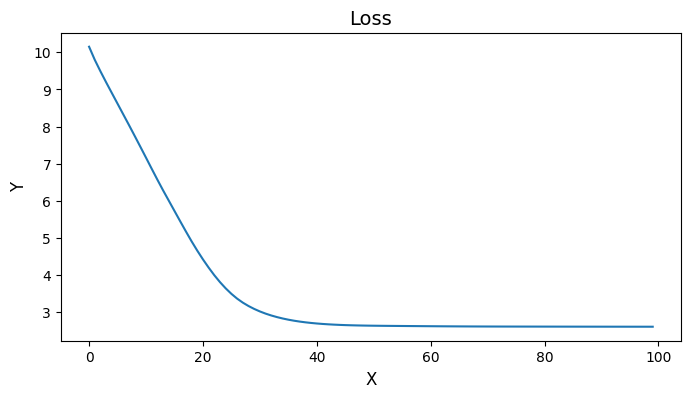

In [29]:
import matplotlib.pyplot as plt

# 步骤2：创建画布（可选，默认会自动创建）
plt.figure(figsize=(8, 4))  # 设置画布大小，宽8英寸，高4英寸
# 步骤3：绘制折线图
plt.plot(list(range(len(loss_arr))), loss_arr)  # 核心函数：plot(x轴数据, y轴数据)
# 步骤4：添加标签、标题等装饰
plt.xlabel('X', fontsize=12)  # x轴标签
plt.ylabel('Y', fontsize=12)  # y轴标签
plt.title('Loss', fontsize=14)  # 图表标题

# 步骤5：显示图表
plt.show()

In [33]:
print(tokenizer.model_max_length) # 最大上下文长度  512
def generate(str,max_len=256): # 总长度尽量不要超过 512
    for i in range(max_len):
        token = tokenizer([str],return_tensors="pt") # 分词   return_tensors="pt" 指定返回 torch.tensor 格式
        token=token.to(device)
        res = llm(input_ids=token.input_ids,attention_mask=token.attention_mask,token_type_ids=token.token_type_ids)
        res = F.softmax(res, dim=-1)
        size = res.shape[1]
        res =res[:,size-1:].view(-1)   # 只要预测的最后一个词即可
        res = torch.multinomial(res, num_samples=1)
        res= tokenizer.decode(res) # 解码为中文
        str+=res # 添加进字符串用于下轮预测
    return str  # 返回最终结果

print(generate("我是",max_len=32))

512
我是articlesimon##蓝[CLS]##察，##缨kiss##展是最喜最欢[SEP]神[SEP][CLS]欢[SEP]玩玩玩[CLS]，是我康pizza了[SEP]神
